In [2]:
import numpy as np
import torch
import torch.nn as nn
import gym
from tqdm import tqdm
import optuna

import random
from collections import deque
from copy import deepcopy

In [3]:
class OUNoise:
    def __init__(self, action_dimension, mu=0, theta=0.15, sigma=0.3):
        self.action_dimension = action_dimension
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

In [4]:
class TwoLayersNeuralNetwork(nn.Module):
    def __init__(self, input_dim, layer1_dim, layer2_dim, output_dim, output_tanh):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, layer1_dim)
        self.layer2 = nn.Linear(layer1_dim, layer2_dim)
        self.layer3 = nn.Linear(layer2_dim, output_dim)
        self.output_tanh = output_tanh
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, input):
        hidden = self.layer1(input)
        hidden = self.relu(hidden)
        hidden = self.layer2(hidden)
        hidden = self.relu(hidden)
        output = self.layer3(hidden)
        
        if self.output_tanh:
            return self.tanh(output)
        else:
            return output

In [5]:
class DDPG:
    def __init__(self, state_dim, action_dim, action_scale, noise_decrease,
                 gamma=0.99, batch_size=64, q_lr=1e-3, pi_lr=1e-4, tau=1e-2, memory_size=100000):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_scale = action_scale
        self.pi_model = TwoLayersNeuralNetwork(self.state_dim, 400, 300, self.action_dim, output_tanh=True)
        self.q_model = TwoLayersNeuralNetwork(self.state_dim + self.action_dim, 400, 300, 1, output_tanh=False)
        self.pi_target_model = deepcopy(self.pi_model)
        self.q_target_model = deepcopy(self.q_model)
        self.noise = OUNoise(self.action_dim)
        self.noise_threshold = 1
        self.noise_decrease = noise_decrease
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.q_optimazer = torch.optim.Adam(self.q_model.parameters(), lr=q_lr)
        self.pi_optimazer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.memory = deque(maxlen=memory_size)
    
    def get_action(self, state):
        pred_action = self.pi_model(torch.FloatTensor(state)).detach().numpy()
        action = self.action_scale * (pred_action + self.noise_threshold * self.noise.sample())
        return np.clip(action, -self.action_scale, self.action_scale)
    
    def update_target_model(self, target_model, model, optimazer, loss):
        optimazer.zero_grad()
        loss.backward()
        optimazer.step()
        for target_param, param in zip(target_model.parameters(), model.parameters()):
            target_param.data.copy_((1 - self.tau) * target_param.data + self.tau * param.data) 
    
    
    def fit(self, state, action, reward, done, next_state):
        self.memory.append([state, action, reward, done, next_state])
        
        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.FloatTensor, zip(*batch))
            rewards = rewards.reshape(self.batch_size, 1)
            dones = dones.reshape(self.batch_size, 1)
            
            pred_next_actions = self.action_scale * self.pi_target_model(next_states)
            next_states_and_pred_next_actions = torch.cat((next_states, pred_next_actions), dim=1)
            targets = rewards + self.gamma * (1 - dones) * self.q_target_model(next_states_and_pred_next_actions)
            
            states_and_actions = torch.cat((states, actions), dim=1)
            temp = (self.q_model(states_and_actions) - targets.detach())
            q_loss = torch.mean((targets.detach() - self.q_model(states_and_actions)) ** 2)
            self.update_target_model(self.q_target_model, self.q_model, self.q_optimazer, q_loss)
            
            pred_actions = self.action_scale * self.pi_model(states)
            states_and_pred_actions = torch.cat((states, pred_actions), dim=1)
            pi_loss = - torch.mean(self.q_model(states_and_pred_actions))
            self.update_target_model(self.pi_target_model, self.pi_model, self.pi_optimazer, pi_loss)
            
        if self.noise_threshold > 0:
            self.noise_threshold = max(0, self.noise_threshold - self.noise_decrease)

In [23]:
import matplotlib.pyplot as plt
from matplotlib import animation

def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    anim.save(path + filename, writer='pillow', fps=60)

In [16]:
EPISODE_N = 200
TRAJECTORY_LEN = 200

env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

memory = {}

def objective(trial):
    params = {
        'gamma': trial.suggest_float('gamma', 0.95, 0.999),
        'batch_size': trial.suggest_int('batch_size', 64, 512, 128),
        'q_lr': trial.suggest_float('q_lr', 1e-5, 1e-1, log=True),
        'pi_lr': trial.suggest_float('pi_lr', 1e-5, 1e-1, log=True),
        'tau': trial.suggest_float('tau', 1e-5, 1e-1, log=True),
    }
    
    default_params = {
        'state_dim': env.observation_space.shape[0],
        'action_dim': env.action_space.shape[0],
        'action_scale': 2,
        'noise_decrease': 1 / (EPISODE_N * TRAJECTORY_LEN)
        
    }
    
    params.update(default_params)
    
    agent = DDPG(**params)
    max_total_reward = -float('inf')
    results = {'total_rewards': [], 'frames': []}
    for _ in tqdm(range(EPISODE_N)):
        total_reward = 0
        frames = []
        state = env.reset()
        for _ in range(TRAJECTORY_LEN):
            action = agent.get_action(state)
            next_action, reward, done, _ = env.step(action)
            total_reward += reward

            agent.fit(state, action, reward, done, next_action)

            if done:
                break

            frames.append(env.render(mode="rgb_array"))
            state = next_action
        if total_reward > max_total_reward:
            max_total_reward = total_reward

        results['frames'] = frames
        results['total_rewards'].append(total_reward)
    print(trial.number, max_total_reward)
    memory[trial.number] = results
    return max_total_reward

C:\Users\marka\anaconda3\envs\drl_ods_2022\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\marka\anaconda3\envs\drl_ods_2022\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [17]:
study = optuna.create_study()
study.optimize(objective, n_trials=5)

[I 2023-01-06 19:09:08,770] A new study created in memory with name: no-name-e8f0e837-0ef5-421a-80eb-7c82fc273bdc
C:\Users\marka\anaconda3\envs\drl_ods_2022\lib\site-packages\optuna\distributions.py:683: UserWarning: The distribution is specified by [64, 512] and step=128, but the range is not divisible by `step`. It will be replaced by [64, 448].
  warnings.warn(
  0%|          | 0/200 [00:00<?, ?it/s]C:\Users\marka\anaconda3\envs\drl_ods_2022\lib\site-packages\gym\core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
100%|██████████| 200/200 [11:09<00:00,  3.35s/it]
[I 2023-01-06 19:20:18,547] Trial 0 finished with value: -922.8761726546236 and parameters: {'gamma': 0.9577540291130957, 'batch_size': 64, 'q_lr': 0.0009359079947401895, 'pi_lr': 0.009744332496124433, 'tau': 0.00011935636794670495}. Best is trial

0 -922.8761726546236


100%|██████████| 200/200 [18:17<00:00,  5.49s/it]
[I 2023-01-06 19:38:36,111] Trial 1 finished with value: -0.08081690547874738 and parameters: {'gamma': 0.950387926018559, 'batch_size': 448, 'q_lr': 0.00013914777401228748, 'pi_lr': 0.0001710890969148858, 'tau': 0.00277620769531692}. Best is trial 0 with value: -922.8761726546236.


1 -0.08081690547874738


100%|██████████| 200/200 [14:25<00:00,  4.33s/it]
[I 2023-01-06 19:53:01,227] Trial 2 finished with value: -0.7205272080337028 and parameters: {'gamma': 0.9895022016535842, 'batch_size': 192, 'q_lr': 0.00025927706324860604, 'pi_lr': 0.02049617302707764, 'tau': 0.05481375557177994}. Best is trial 0 with value: -922.8761726546236.


2 -0.7205272080337028


100%|██████████| 200/200 [12:05<00:00,  3.63s/it]
[I 2023-01-06 20:05:06,273] Trial 3 finished with value: -0.9144065064933763 and parameters: {'gamma': 0.9870567282111629, 'batch_size': 64, 'q_lr': 0.0016610690905400347, 'pi_lr': 0.0011183736530705805, 'tau': 0.0007165660840939694}. Best is trial 0 with value: -922.8761726546236.


3 -0.9144065064933763


100%|██████████| 200/200 [17:02<00:00,  5.11s/it]
[I 2023-01-06 20:22:09,001] Trial 4 finished with value: -773.6039049647718 and parameters: {'gamma': 0.957135469791779, 'batch_size': 320, 'q_lr': 0.0003609681257154031, 'pi_lr': 0.005556947150034269, 'tau': 0.0012236282620349402}. Best is trial 0 with value: -922.8761726546236.


4 -773.6039049647718


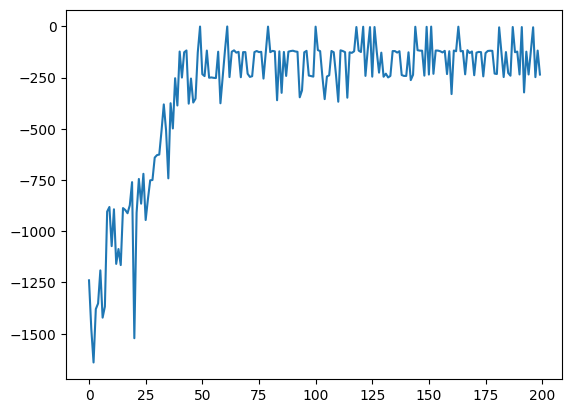

In [21]:
plt.plot(memory[2]['total_rewards'])

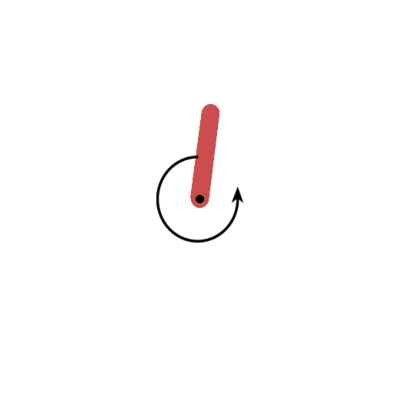

In [24]:
save_frames_as_gif(memory[2]['frames'], filename='task1.gif')